In [17]:
#运行次数
e_count = 4

In [1197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
#倒入一些必要的库

In [1198]:
#feanum=17#一共有多少特征
window=24#时间窗设置
#df1=pd.read_csv('../Resource/Bloomsbury.csv') #读取数据
#df1=pd.read_csv('../Resource/FLUXNET2015/FLX_AU-TTE_FLUXNET2015_FULLSET_DD_2012-2014_1-3.csv') #读取数据 这个在测试集上表现较差
#df1=pd.read_csv('../Resource/FLUXNET2015/FLX_CA-TPD_FLUXNET2015_FULLSET_DD_2012-2014_1-3.csv') #读取数据
#df1=pd.read_csv('../Resource/FLUXNET2015/FLX_JP-MBF_FLUXNET2015_SUBSET_HH_2003-2005_1-4_clean.csv') #读取数据
#df1=pd.read_excel('../Resource/ExperimentDataBase/CV1(1).xlsx')
#df1 = pd.read_csv('../Resource/InformerData/ETTh1.csv')
df1 = pd.read_csv('../Resource/FLUXNET2015/FLX_CA-TPD_FLUXNET2015_FULLSET_DD_2012-2014_1-3_Normal.csv')
l=len(df1)
df1=df1.iloc[:,1:]#删除前1列没用的
#删除包含NaN值的行

# SW_IN_F :短波辐射，来自SW_IN_F_MDS和SW_IN_ERA的综合入射（负值设为零）。
#TA_F:空气温度，由TA_F_MDS和TA_ERA合并而成
# WS_F:风速，由WS和WS_ERA合并而成
#RH:相对湿度，范围0-100

In [1199]:
df1.head()

,Ra,SW_IN_F,TA_F,P_F,WS_F,TA_D,RH,acpcp,apcp,dswrf,gust,spfh,tmax,tmin
0,485.92,42.413,3.064,0.073,3.629,3.325,72.322500,0.01,0.01,250,40.47905,1.240451,-2.75,-3.89
1,485.92,42.413,3.064,0.073,3.629,3.325,71.208000,0.01,0.01,250,40.47905,1.240451,-2.75,-3.89
2,488.25,96.863,6.389,0.000,5.842,-0.916,60.981250,0.00,0.00,173,62.52610,1.895508,2.42,0.28
3,490.72,96.863,5.473,0.000,3.706,-4.644,51.469444,0.11,0.30,240,36.31510,1.652000,3.21,2.87
4,493.33,56.762,0.829,0.060,2.345,2.152,59.865000,0.11,0.10,369,24.16555,1.088033,0.87,-1.03


In [1200]:
# 删除包含NaN值的列：df.dropna(axis=1)
# 仅删除所有值都为NaN的行：df.dropna(how='all')
# 仅删除指定列中包含NaN值的行：df.dropna(subset=['column1', 'column2'])

In [1201]:
#print(len(df1.iloc[0]))

In [1202]:
#print(df1.iloc[:,-1])
#print(df1.iloc[1:10,1])

## 数据降维

In [1203]:
# PCA降维
#from sklearn.decomposition import PCA
#pca = PCA(n_components=4) # 指定降维后的维度为2
#X_new = pca.fit_transform(df1) # X为原始数据，X_new为降维后的数据
# # LDA降维
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# lda = LDA(n_components=2) # 指定降维后的维度为2
# X_new = lda.fit_transform(X, y) # X为原始数据，y为标签，X_new为降维后的数据

In [1204]:
from sklearn import preprocessing#进行归一化操作
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0,columns=df1.columns)
dfs = df.to_numpy()
#print("dfs:",dfs[300:330])

# 这里y_train = train[:, -1][:,1] , 其中把每一层数据中的第第二例数据（[:,1]）作为y进行训练，也就是可以进行对第二列数据进行预测

In [1205]:
#这一部分在处理数据 将原始数据改造为模型需要的输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.to_numpy() #pd.DataFrame(stock) 表格转化为矩阵
print("data_len:",len(data))
sequence_length = seq_len + 1#序列长度+1 加1作为标签？
result = []
for index in range(len(data) - sequence_length):#循环 数据长度-时间窗长度 次 17520-5
    #print("index",index) index = 0...range(len(data)-sequence_length)
    result.append(data[index: index + sequence_length])#第i行到i+5 ,[0:6],[1:7],[2:8] -> data={[0:5],[1:6],[2:7]...[17514:17514+5]} ->分为序列数据(5行作为一个序列=4个小时为基础单位-作为训练)
result = np.array(result)#得到样本，样本形式为 window*feanum
#print(result) #每行是基础数据的前六行数据,
#print("2",result[1:3]) #每行是基础数据的前六行数据,
#test21 = []
#test21 =  result[1:6]
#print("rest[1:3]:",test21)
# print("test21[:,-1]:",test21[:,-1])#取所有层的每层中的最后一行数据
#print("test21[:,-1][:,-1]:",test21[:,-1][:,1])#取所有层的每层中的最后一行数据中的最后一列数据
# print("test21[:,:-1]:",test21[:,:-1])#除了每层中的最后一行都取

# test31 = result[1:3][:,-1] # 这句代码的意思是：取三维数组的第一块数据到第四块数据(在三维中可以理解成前两层),[:4]为:取前两层的数据中的每块（层）中的最后一行数据
# #如果等于[1:3][:-1] :取前两层中的每层中的最后一行数据
# print("test31",test31)
cut=165#分训练集测试集 最后cut个样本为测试集
train = result[:-cut, :] # 训练集为第零行到倒数第cut=150行,默认取所有列
x_train = train[:, :-1] #除了每层中的最后一行都取
y_train = train[:, -1][:,1] #取所有层的每层中的最后一行数据中的最后一列数据(当等于-1的时候)
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,1]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
# print("X_train.shape[0]:",x_train.shape[0])
# print("X_train.shape[1]:",x_train.shape[1])
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
# print("X_test.shape[0]:",x_test.shape[0])
# print("X_test.shape[1]:",x_test.shape[1])

data_len: 1067


In [1206]:
print((np.array(result)).shape)

(1042, 25, 14)


In [1207]:
e_count = e_count + 1

In [1208]:
print(e_count)

68


### 查看训练集和测试集是否在同一分布下

# 曲线绘制测试

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_2832\4211843346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train, hist=True, kde=False, label='Train Data')
C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_2832\4211843346.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_test, hist=True

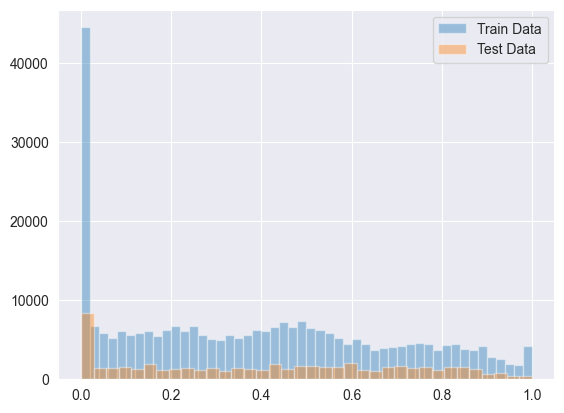

In [1209]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制直方图
sns.distplot(x_train, hist=True, kde=False, label='Train Data')
sns.distplot(x_test, hist=True, kde=False, label='Test Data')

plt.legend()
plt.savefig('../Result/SVM_Image/Zero_Three_Col_FLX_AU{}.png'.format(e_count))
plt.show()

In [1210]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# x = np.linspace(0, 5, 50)
# y_train_show = y_train[100:400]
#
# # 将数据转换成pandas的Series类型，并进行滑动平均处理
# df = pd.Series(y_train_show).rolling(window=5).mean()
#
# # 绘制平滑后的曲线
# plt.figure(figsize=(12,6))
# plt.plot(df)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Test')
# plt.show()


In [1211]:
#print("train_set:",x_train[17363]) #数据为     17364个块(窗口)  <- 5行数据为一个序列=时间窗口 <- 一行数据(八个特征)

In [1212]:
#展示下训练集测试集的形状 看有没有问题
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (877, 24, 14)
y_train (877,)
X_test (165, 24, 14)
y_test (165,)


In [1213]:
print("Length X_train:",len(X_train))
print("Length y_train:",len(y_train))
print("cut",cut)
print("X_test:",len(X_test))
print("y_test:",len(y_test))

Length X_train: 877
Length y_train: 877
cut 165
X_test: 165
y_test: 165


In [1214]:
#更改数组shape
X_train=X_train.reshape(len(X_train),window*(len(df1.iloc[0]))) #17365 * 4 * 8 = 557120 = 17365*32
y_train=y_train.reshape(len(X_train)) # 17365
X_test=X_test.reshape(cut,window*(len(df1.iloc[0]))) # 150 * 4 * 8 = 150 * 32(window)
y_test=y_test.reshape(cut) # 150
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (877, 336)
y_train (877,)
X_test (165, 336)
y_test (165,)


In [1215]:
# print(y_train)

In [1216]:
# Fit regression model
from sklearn.svm import SVR  
# svr = SVR(kernel='rbf',C=10)
# model = svr.fit(X_train, y_train)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Grid search for best hyperparameters
#这里使用网格搜索方法，对正则化参数C和核函数的参数gamma进行了调整，并使用交叉验证来选择最佳的超参数。在训练集和测试集上分别计算了均方误差（MSE）。
param_grid = {
    'C': [0.01,0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
}

grid_search = GridSearchCV(SVR(kernel='poly'), param_grid, cv=5, scoring='neg_mean_squared_error')

# 初始化三个不同的回归模型
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=10)


# 构建模型集成器
model = VotingRegressor(estimators=[('lr', lr), ('rf', rf), ('svr', grid_search)])

# 拟合模型并进行预测
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)#训练集上的预测结果
y_pred_test = model.predict(X_test)#测试集预测结果

#grid_search.fit(X_train, y_train)

# Train and evaluate model
#model = grid_search.best_estimator_
#y_pred_train = model.predict(X_train)
#y_pred_test = model.predict(X_test)

print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
# print("Test MSE:", mean_squared_error(y_test, y_pred_test))

Train MSE: 0.005037625485994496
Test MSE: 0.01103968399250714


In [1017]:
#简单模型预测
# Fit regression model
from sklearn.svm import SVR
svr = SVR(kernel='poly')
model = svr.fit(X_train, y_train)

# 拟合模型并进行预测
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)#训练集上的预测结果
y_pred_test = model.predict(X_test)#测试集预测结果
print(model)

SVR(kernel='poly')


In [475]:
param_grid = {
    'C': [0.01,0.1, 1, 10, 100,1000],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
}

grid_search = GridSearchCV(SVR(kernel='linear'), param_grid, cv=5, scoring='neg_mean_squared_error')
model = grid_search.fit(X_train, y_train)
# 拟合模型并进行预测
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)#训练集上的预测结果
y_pred_test = model.predict(X_test)#测试集预测结果

In [1114]:
#在训练集上的拟合结果
# y_train_predict=model.predict(X_train)

In [1115]:
# print(y_train_predict)

            0         0
0    0.041346  0.067954
1    0.113280  0.104931
2    0.238883  0.288434
3    0.309298  0.327554
4    0.136848  0.182856
..        ...       ...
872  0.941877  0.885269
873  0.880469  0.823782
874  0.550087  0.637257
875  0.517206  0.584590
876  0.926819  0.829054

[877 rows x 2 columns]
R方: 0.9381335061396513


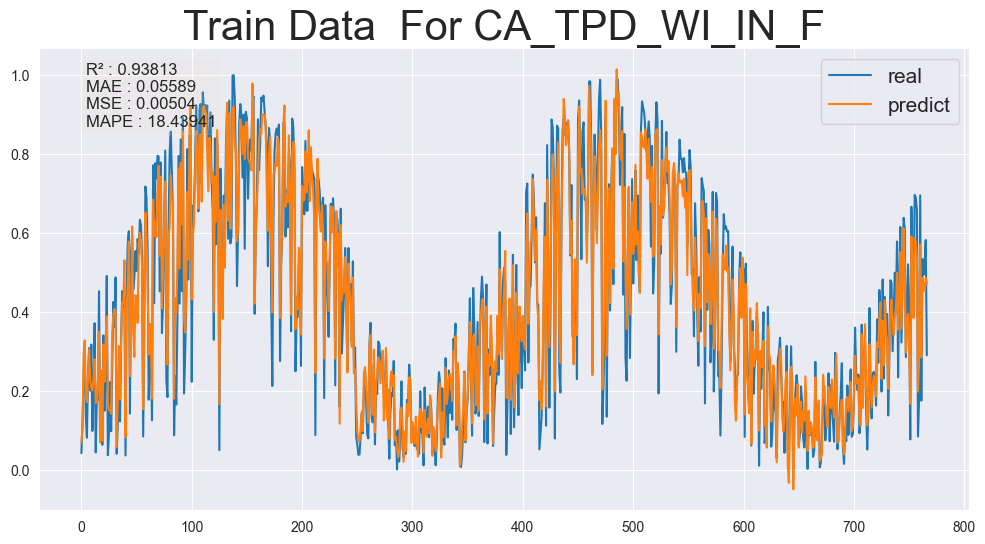

In [1217]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_pred_train)],axis=1)
draw.iloc[0:767,0].plot(figsize=(12,6))
draw.iloc[0:767,1].plot(figsize=(12,6))
print(draw)
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data  For CA_TPD_WI_IN_F",fontsize='30') #添加标题
#展示在训练集上的表现
from sklearn.metrics import r2_score
r2 = r2_score(y_train,y_pred_train)
# plt.text(0.01, 0.95, 'R² - {:.5f}'.format(r2),transform=plt.gca().transAxes, fontsize=13)
# plt.text(0.01, 0.87, 'MAE - {:.5f}'.format(mean_absolute_error(y_pred_train, y_train)), transform=plt.gca().transAxes, fontsize=13)
# plt.text(0.01, 0.79, 'MSE - {:.5f}'.format(mean_squared_error(y_pred_train, y_train)), transform=plt.gca().transAxes, fontsize=13)
# plt.text(0.01, 0.71, 'MAPE - {:.5f}'.format(mape(y_pred_train, y_train) ), transform=plt.gca().transAxes, fontsize=13)
textstr = '\n'.join((
    'R² : {:.5f}'.format(r2),
    'MAE : {:.5f}'.format(mean_absolute_error(y_pred_train, y_train)),
    'MSE : {:.5f}'.format(mean_squared_error(y_pred_train, y_train)),
    'MAPE : {:.5f}'.format(mape(y_pred_train, y_train))))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)

plt.text(0.05, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=props)
print("R方:",r2)
plt.savefig('../Result/SVM_Image/SVM_TrainData_AU_TTE_WI_IN_F_Three_Zero_Col_Prediction_{}.png'.format(e_count))

In [1218]:
#在测试集上的预测
# y_test_predict=model.predict(X_test)


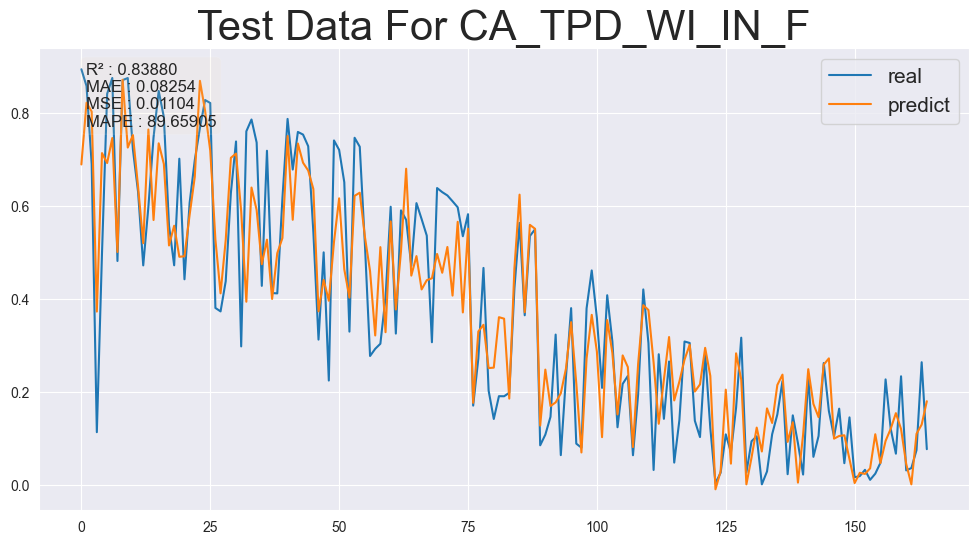

In [1219]:
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_test)],axis=1);
# print(draw.iloc[:])
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data For CA_TPD_WI_IN_F",fontsize='30') #添加标题

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred_test)
# plt.text(0.01, 0.95, 'R² - {:.5f}'.format(r2),transform=plt.gca().transAxes, fontsize=13)
# plt.text(0.01, 0.87, 'MAE - {:.5f}'.format(mean_absolute_error(y_pred_train, y_train)), transform=plt.gca().transAxes, fontsize=13)
# plt.text(0.01, 0.79, 'MSE - {:.5f}'.format(mean_squared_error(y_pred_train, y_train)), transform=plt.gca().transAxes, fontsize=13)
# plt.text(0.01, 0.71, 'MAPE - {:.5f}'.format(mape(y_pred_train, y_train) ), transform=plt.gca().transAxes, fontsize=13)
textstr = '\n'.join((
    'R² : {:.5f}'.format(r2),
    'MAE : {:.5f}'.format(mean_absolute_error(y_pred_test, y_test)),
    'MSE : {:.5f}'.format(mean_squared_error(y_pred_test, y_test)),
    'MAPE : {:.5f}'.format(mape(y_pred_test, y_test))))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)

plt.text(0.05, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=props)
#展示在测试集上的表现
#保存图片
plt.savefig('../Result/SVM_Image/SVM_TestData_AU_TTE_WI_IN_Fx_Three_Col_Prediction_{}.png'.format(e_count))

In [174]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_pred_train, y_train))
print(mean_squared_error(y_pred_train, y_train) )
print(mape(y_pred_train, y_train) )
print('测试集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_pred_test, y_test))
print(mean_squared_error(y_pred_test, y_test) )
print(mape(y_pred_test, y_test) )
r2_score(y_test,y_pred_test)

## 为什么MAPE那么高？

训练集上的MAE/MSE/MAPE
0.024128918146419383
0.0011145086146121615
7.731123343564141
测试集上的MAE/MSE/MAPE
0.028347553690501535
0.0011483740108581427
7.436353530083201


0.9683846645030155

## 添加预测绘图结果